In [1]:
import os
import re
import time
import shutil
import argparse
import numpy as np
import pandas as pd
import preprocessing as pp
import prompt_adapter as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm,trange
from datetime import datetime
from llm_client import llm_client
from preprocessing import pipeline
from llmbt import LLMBoostingClassifier
from sklearn.model_selection import train_test_split
from typing import Tuple, Set, Optional, List, Dict, Union

In [2]:
from enum import Enum
class QueryStatus(Enum):
    UNK = 0
    OK = 1
    FER = 2 #format error
    NTR = 3 #network error

## Data Preprocessing

In [3]:
original_table = pd.read_csv('./dataset/csic_database_preprocessed.csv')
original_table.drop(columns=['URL', 'content'], inplace=True) #for time series model analysis
original_table.head()

,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,68.0
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,63.0


In [4]:
preprocessed_table = pipeline(
    table = original_table,
    funcs = [
        pp.rename_column,
        #pp.sample_rows, #sample rows by label
        pp.remove_unique_columns,
        pp.fill_with_average,
        pp.fill_string_nan_with_none,
        pp.onehot_table
    ],
    args = [
        {'old_col':'Unnamed: 0', 'new_col':'label'},
        #{},
        {},
        {},
        {},
        {'exclude_columns':['label']}
    ]
)

rename_column Unnamed: 0 with label
(61065, 14)
remove_unique_columns ...
(61065, 7)
fill_with_average ...
(61065, 7)
fill_string_nan_with_none ...
(61065, 7)
onehot_table ...
(61065, 13)


In [5]:
preprocessed_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61065 entries, 0 to 61064
Data columns (total 13 columns):
 #   Column                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                         --------------  -----  
 0   label                                                                                                          61065 non-null  object 
 1   lenght                                                                                                         61065 non-null  float64
 2   Method_is_GET                                                                                                  61065 non-null  bool   
 3   Method_is_POST                                                                                                 61065 non-null  bool   
 4   Method_is_PUT                                 

### split train and test dataset

In [6]:
train_table, test_table = train_test_split(preprocessed_table, test_size=0.9)
print(len(train_table), len(test_table))

6106 54959


#### mapping label to int

In [10]:
def is_numeric(column):
    if column.dtype == bool:
        return False
    else:
        return pd.api.types.is_numeric_dtype(column)

#return range and type
def get_feature_info(table):
    feature_range = {} #feature name : range
    feature_type = {} #1 is number 0 is category
    for col in table.columns:
        if is_numeric(table[col]):
            feature_range[col] = (table[col].min(), table[col].max()) #number to max and min
            feature_type[col] = 1
        else:
            feature_range[col] = table[col].unique().tolist() #to category
            feature_type[col] = 0
    return feature_range,feature_type

In [11]:
target_names = ['Normal', 'Anomalous']
feature_names = preprocessed_table.drop(columns=['label']).columns.tolist()
feature_ranges,feature_types = get_feature_info(preprocessed_table.drop(columns=['label']))
train_x = train_table.drop(columns=['label']).to_numpy()
train_y = train_table['label'].apply(lambda x: target_names.index(x)).to_numpy()
test_x = test_table.drop(columns=['label']).to_numpy()
test_y = test_table['label'].apply(lambda x: target_names.index(x)).to_numpy()

## Description
#### include desc, role and feature detail mapping

In [14]:
desc = """
The HTTP dataset CSIC 2010 contains thousands of web requests automatically generated. \
It can be used for the testing of web attack protection systems. It was developed at the "Information Security Institute" \
of CSIC (Spanish Research National Council). This dataset contains two type label: Normal or Anomalous.
"""
role = 'expert of cyber security'
feature_detail = {'lenght':'Content-Length'}

## Build the Tree

In [15]:
TOPK_RECALL = 4
TEMPERATURE = 0.4
SELECTION_KEYS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' 

### for reference

In [40]:
from base_tree import DecisionTreeClassifier
from visual import print_tree

In [41]:
# Create a Decision Tree classifier
dtc = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best',
    random_state=42, 
    max_depth=6,
    feature_name=feature_names,
    class_name=target_names
)
# Fit the classifier to the training data
dtc.fit(train_x, train_y)
print(dtc.score(train_x, train_y), dtc.score(test_x, test_y))

0.6703242712086472 0.6634218235411853


/home/liangxj/workspace/MLLLM/visual.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(fontsize=fontsize, fancybox=True, framealpha=0.0, labelspacing=1.5)


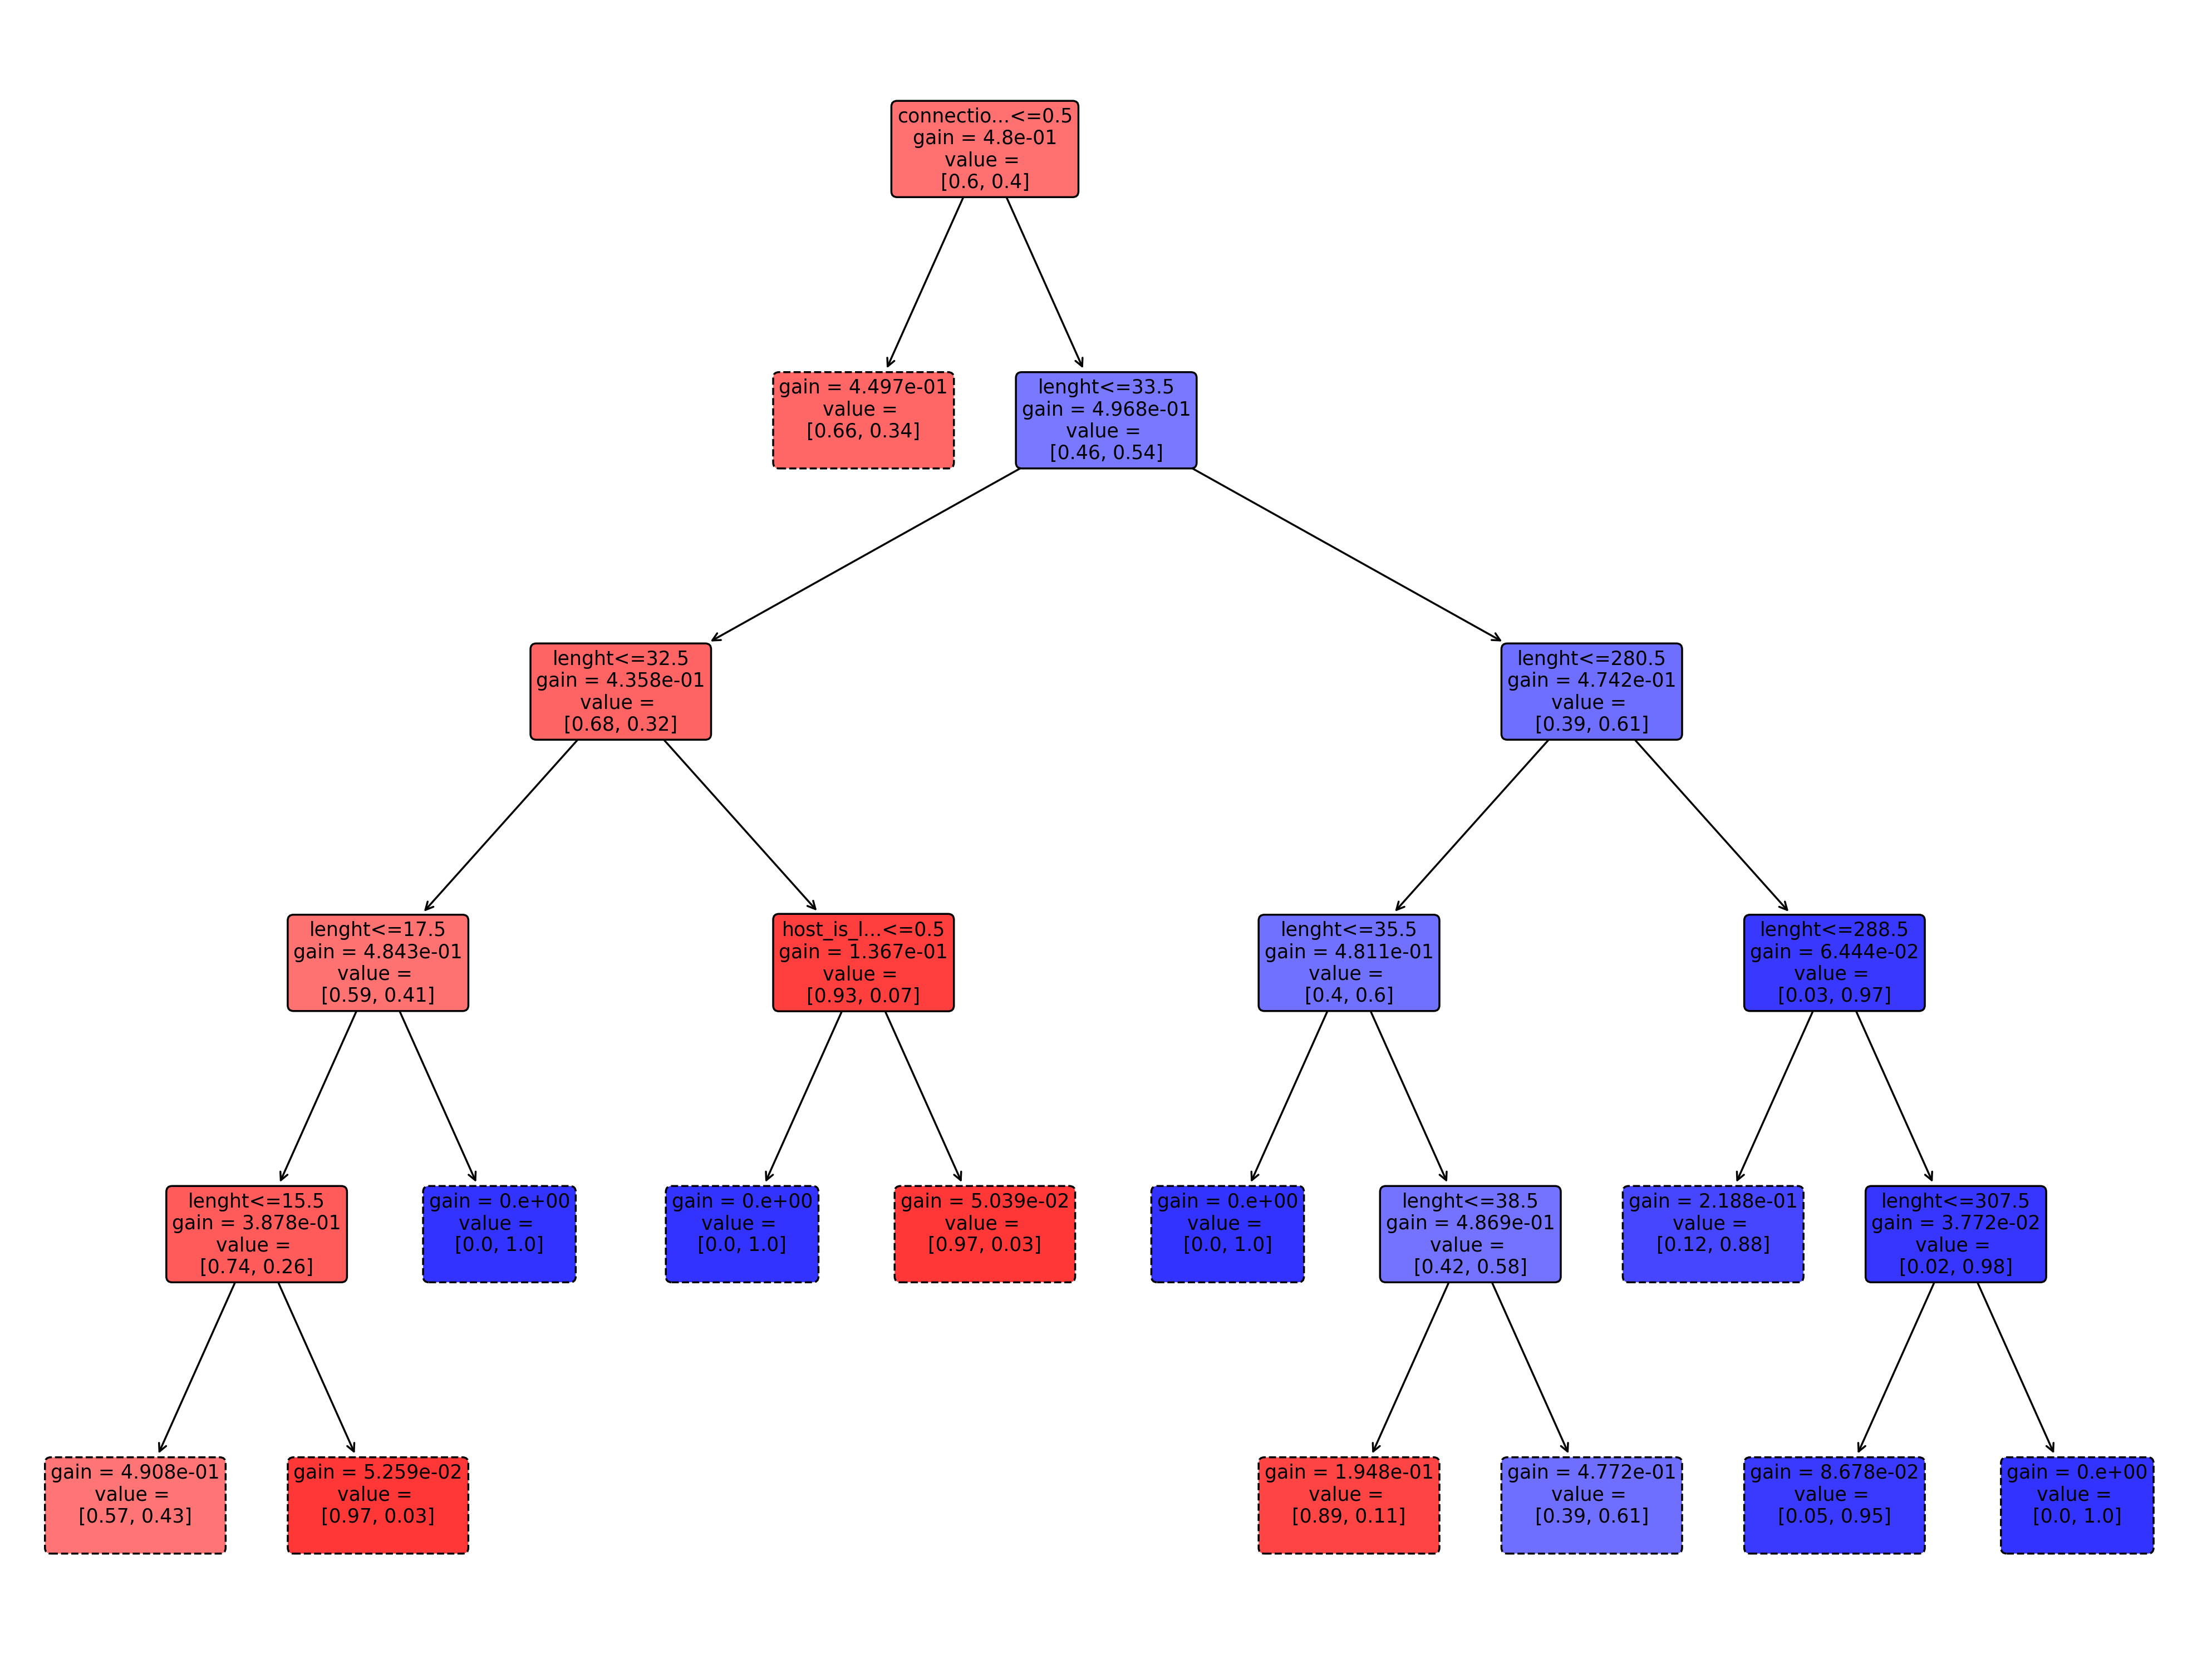

In [43]:
print_tree(
    tree=dtc,
    feature_names=feature_names,
    class_names=target_names,
    is_classifier=True,
    figsize = (16, 12),
    fontsize = 10,
    dpi=250
)

In [78]:
def shuffle_arrays(x, y):
    # Ensure x and y are numpy arrays
    x = np.array(x)
    y = np.array(y)
    # Check that both arrays have the same length
    if len(x) != len(y):
        raise ValueError("Arrays must have the same length.")
    # Generate a permutation of indices based on the length of the arrays
    permutation = np.random.permutation(len(x))
    # Apply the permutation to both arrays
    x_shuffled = x[permutation]
    y_shuffled = y[permutation]
    return x_shuffled.tolist(), y_shuffled.tolist()    

'''
options_dicts: [{}, {}, {}]
which contains like that:
option={
    'feature':'Al Aluminum',
    'val_range':(0.1, 0.5),
    'det':'<',
    'val':0.25,
    'condition':{'possibility':97.3, 'result':'building_windows_non_float_processed'}
}
'''
def make_selection(llm_cli, desc:str, role:str, options_dicts:List[Dict], selection_keys:str, premise=None):
    index2options = {}
    index2keys,keys2index = {},{}
    option_list = []
    selection_keys = [selection_keys[i] for i in range(len(options_dicts))] #cut off
    for index,(op_dict, key) in enumerate(zip(options_dicts, selection_keys)):
        optext = pa._get_option(**op_dict)
        option_list.append(optext)
        index2options[index] = optext #for reverse
        index2keys[index] = key
        keys2index[key] = index
    #shuffle
    option_list,selection_keys = shuffle_arrays(option_list, selection_keys)
    #to text
    option_tag, option_text = pa.options2text(option_list, selection_keys)
    selection_prompt = pa.get_selection_prompt(
        desc=desc.strip(),
        role=role.strip(),
        options=option_text,
        premise=premise
    )
    print('\n###################### SELECTION ######################')
    print(selection_prompt)
    status,response,num_toks,repeat = llm_cli.generate(question=pa.selection_shots + selection_prompt, temperature=TEMPERATURE)
    print(response)
    if status:
        status,answer = pa.get_selection_result(selection_keys, response)
        if status:
            key, reason = answer[0], answer[-1]
            return QueryStatus.OK, (keys2index[key], reason)
        return QueryStatus.FER, None
    else:
        return QueryStatus.NTR, None

'''
see make_selection
'''
def make_explanation(llm_cli, desc:str, role:str, opt_selected:str, premise=None):
    explanation_prompt = pa.get_explanation_prompt(
        desc=desc.strip(),
        role=role.strip(),
        query=opt_selected,
        premise=premise
    )
    print('\n###################### EXPLANATION ######################')
    print(explanation_prompt)
    status,response,num_toks,repeat = llm_cli.generate(question=pa.explanation_shots + explanation_prompt, temperature=TEMPERATURE)
    print(response)
    if status:
        status,answer = pa.get_explanation_result(response)
        if status:
            return QueryStatus.OK, answer
        return QueryStatus.FER, None
    else:
        return QueryStatus.NTR, None

In [83]:
'''
splits,explanation,selection = \
    split_call(candidate_feature, candidate_theshold, candidate_gain,candidate_indice)
best_feature,best_theshold,best_gain,best_split = splits[0],splits[1],splits[2],splits[3]
input: 
    all of them are sorted by gain (smaller, better)
    candidate_feature: <class 'tuple'> #list of features index 
    candidate_theshold: <class 'tuple'> #list of features value
    candidate_gain: <class 'tuple'> #list of maximun gain of each feature
    candidate_indice: <class 'tuple'> #[feature len, 2, [split length]]
    Y: [N, n_class]
'''
def split_call(candidate_feature, candidate_theshold, candidate_gain, candidate_indice, Y, premise=None):
    global desc
    global role
    global feature_names
    global feature_ranges
    global feature_types
    global target_names
    global llm_cli
    options = []
    for index in range(TOPK_RECALL):
        feature_name_ = feature_names[candidate_feature[index]]
        feature_range_ = feature_ranges[feature_name_]
        split_index = candidate_indice[index]
        possibility_left = np.sum(Y[split_index[0]], axis=0)/np.sum(Y[split_index[0]])
        possibility_right = np.sum(Y[split_index[-1]], axis=0)/np.sum(Y[split_index[-1]])
        det, val, possibility, result = None, None, None, None 
        if np.max(possibility_left) > np.max(possibility_right):
            if feature_types[feature_name_]==1:
                det = '<'  #number or category 
                val = candidate_theshold[index]
            else:
                det = '' #number or category 
                val = False
            possibility = possibility_left * 100.0
            result = target_names[np.argmax(possibility_left)]
        else:
            if feature_types[feature_name_]==1:
                det = '>'  #number or category 
                val = candidate_theshold[index]
            else:
                det = '' #number or category 
                val = True
            possibility = possibility_right * 100.0
            result = target_names[np.argmax(possibility_right)]
        opt = {
                'feature': feature_name_,
                'val_range': feature_range_,
                'det': det,
                'val': val,
                'condition':{'possibility':97.3, 'result':result}
        }
        options.append(opt)
    status,res = make_selection(llm_cli, desc, role, options, str(SELECTION_KEYS), premise) #get selection
    if status == QueryStatus.OK: #selection succeed
        index_selected, reason_selected = res[0], res[-1]
        status,res = make_explanation(llm_cli, desc, role, options[index_selected], premise) 
        explanation = res
        if status == QueryStatus.OK: #explanation succeed
            #return splits,explanation,selection
            import ipdb
            ipdb.set_trace(context=10)
            return (candidate_feature[index_selected], 
                    candidate_theshold[index_selected],
                    candidate_gain[index_selected],
                    candidate_indice[index_selected]), \
                    reason_selected, \
                    explanation
    raise Exception("QueryStatus is not OK")

In [88]:
import imp
import prompt_adapter
imp.reload(prompt_adapter)
import prompt_adapter as pa

In [92]:
import imp
import llmbt
imp.reload(llmbt)
from llmbt import LLMBoostingClassifier, Node

In [89]:
llm_cli = llm_client(
    url='https://api.xiaoai.plus/v1', 
    api_key='sk-dzfmQUflukYgY0mH44EeAe26E0F240DbB6EaD38898Cc405c', 
    models='gpt-4o-mini',
    max_tokens=4096,
    debug=False
)
# Create a Decision Tree classifier
lbc = LLMBoostingClassifier(
    criterion='gini', 
    splitter='llm',
    split_call=split_call,
    random_state=42, 
    max_depth=6,
    feature_name=feature_names,
    class_name=target_names
)
# Fit the classifier to the training data
lbc.fit(train_x, train_y)


###################### SELECTION ######################
Question: The HTTP dataset CSIC 2010 contains thousands of web requests automatically generated. It can be used for the testing of web attack protection systems. It was developed at the "Information Security Institute" of CSIC (Spanish Research National Council). This dataset contains two type label: Normal or Anomalous. Assume you are a expert of cyber securitygiven a group of instances X, which options is the best for further classification?
A. connection_is_Connection: close, category of [False, True], if this feature of X is False, X have a 97.3% chance to be Normal.
B. content-type_is_application/x-www-form-urlencoded, category of [False, True], if this feature of X is False, X have a 97.3% chance to be Normal.
C. content-type_is_None, category of [True, False], if this feature of X is True, X have a 97.3% chance to be Normal.
D. Method_is_GET, category of [True, False], if this feature of X is True, X have a 97.3% chance to

ipdb>  q


## Tree Expansion

In [93]:
def add_node(target_node:Node, new_content:Dict, left_child:Node , right_child:Node):
    target_node.content['is_leave'] = False
    target_node.content.update(new_content)
    target_node.left_child = left_child
    target_node.right_child = right_child

In [ ]:
C_ucb = 1
def UCB(fi, n_all, n_i):
    return fi + C_ucb * (n_all/(ni+1))^0.5    

def get_center_of_bubble(feature_range):
    fr_ = sorted(feature_range, reverse=False)
    gaps = [(fr_[i]-fr_[i-1]) for i in range(1, len(fr_))]
    index = np.argmax(gaps)
    return  (fr_[index+1] + fr_[index]) * 0.5

def get_lowest_freq_value(feature_name, feature_range, tree):
    freq_of_range = tree.get_freq_of_range(feature_name, feature_range)
    return feature_range[np.argmin(freq_of_range)]

def get_topk_feature(feature_name, tree, topk):
    feature_importance_ = tree.feature_importance
    assert len(feature_name) == len(feature_importance_)
    feature_index = list(range(len(feature_name)))
    feature_count = {name:0 for name in feature_name} #feature_name: count
    all_nodes = tree.get_nodes()
    for node in all_nodes:
        feature_count[feature_name[node['feature']]] += 1
    feature_value = [UCB(feature_importance_[fn], len(all_nodes), feature_count[fn]) for fn in feature_name]
    sorted_values = sorted(zip(feature_value, feature_name, feature_index))
    sorted_name,sorted_index = [item[1] for item in sorted_values],[item[2] for item in sorted_values]
    return sorted_name[:topk], sorted_index[:topk]

'''
input:
    feature_name:
    feature_range:
    tree:
'''
def get_feature_threshold(feature_name, feature_range, feature_type, tree):
    if feature_type: #number
        return get_center_of_bubble(feature_range) #big bubble
    else:
        return get_lowest_freq_value(feature_name, feature_range, tree) #low frequence

'''
expansion by LLMs (Random Coarse Selection)
Input:
    candidate_feature: 
    candidate_theshold: 
    premise: 
Output:
    
'''
def expand_call(feature_name, feature_range, feature_type, tree, premise):
    candidate_threshold = get_feature_threshold(feature_name, feature_range, feature_type, tree) #range of feature_name
    candidate_feature_name,candidate_feature_index = get_topk_feature(feature_name, tree, TOPK_RECALL)
    for index in range(TOPK_RECALL):
        

    

In [ ]:
def split_call(candidate_feature, candidate_theshold, candidate_gain, candidate_indice, Y, premise=None):
    global desc
    global role
    global feature_names
    global feature_ranges
    global feature_types
    global target_names
    global llm_cli
    options = []
    for index in range(TOPK_RECALL):
        feature_name_ = feature_names[candidate_feature[index]]
        feature_range_ = feature_ranges[feature_name_]
        split_index = candidate_indice[index]
        possibility_left = np.sum(Y[split_index[0]], axis=0)/np.sum(Y[split_index[0]])
        possibility_right = np.sum(Y[split_index[-1]], axis=0)/np.sum(Y[split_index[-1]])
        det, val, possibility, result = None, None, None, None 
        if np.max(possibility_left) > np.max(possibility_right):
            if feature_types[feature_name_]==1:
                det = '<'  #number or category 
                val = candidate_theshold[index]
            else:
                det = '' #number or category 
                val = False
            possibility = possibility_left * 100.0
            result = target_names[np.argmax(possibility_left)]
        else:
            if feature_types[feature_name_]==1:
                det = '>'  #number or category 
                val = candidate_theshold[index]
            else:
                det = '' #number or category 
                val = True
            possibility = possibility_right * 100.0
            result = target_names[np.argmax(possibility_right)]
        opt = {
                'feature': feature_name_,
                'val_range': feature_range_,
                'det': det,
                'val': val,
                'condition':{'possibility':97.3, 'result':result}
        }
        options.append(opt)
    status,res = make_selection(llm_cli, desc, role, options, str(SELECTION_KEYS), premise) #get selection
    if status == QueryStatus.OK: #selection succeed
        index_selected, reason_selected = res[0], res[-1]
        status,res = make_explanation(llm_cli, desc, role, options[index_selected], premise) 
        explanation = res
        if status == QueryStatus.OK: #explanation succeed
            #return splits,explanation,selection
            import ipdb
            ipdb.set_trace(context=10)
            return (candidate_feature[index_selected], 
                    candidate_theshold[index_selected],
                    candidate_gain[index_selected],
                    candidate_indice[index_selected]), \
                    reason_selected, \
                    explanation
    raise Exception("QueryStatus is not OK")